In [1]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline 
%precision 5

'%.5f'

# Residual and Tangent for Linear Momentum Balance

The linear momentum balance problem can be formulated in terms of tensors that are associated with the reference or the deformed coordinates. They are equivalent, but some computations are easier in the reference and some computations are easier in the deformed configuration expressions. Overall, the discrete equations in the deformed configurations are more sparse and therefore more efficient numerically. 

The residual for the weak form in the reference configuration was achieved in previous lectures by discretizing 

$ \int_{B^e}\mathbf{ \sigma} : \delta \mathbf{d}$ 

First, using the discrete nodal positions from the reference and deformed configurations $\mathbf{X}_i^e$ and $\mathbf{x}_i^e$ respectively, we can compute the discrete deformation gradient $\mathbf{F}$ at any point inside of the element and compute the stress $\mathbf{\sigma}$. Then, by introducing the discrete weight function values or nodal variations $\delta \mathbf{u}_i^e$ and taking these outside of the integral leaving behind the shape functins and gradients, we arrive at the corresponding expression for the element residual $\mathbf{R}^e$. 

For the tangent we need the linearization of the weak form. In the current configuration the linearization of the equations is (see also Wriggers pp 137)

$ \int_{B^e} \mathbf{\sigma}: \nabla (\Delta \mathbf{u})^T \nabla \delta \mathbf{u} + \int_{B^e} \Delta \mathbf{\epsilon}: \mathbf{c}:\delta \mathbf{d}$ 

Introducing the discretizations $\delta \mathbf{u} = \sum N_i \delta \mathbf{u}_i^e$ and $\Delta \mathbf{u} = \sum N_i \Delta \mathbf{u}_i^e$ and taking the noda values $\delta \mathbf{u}_i^e$ and $\Delta \mathbf{u}_i^e$ outside of the integral one is left with the element tangent matrix $\mathbf{K}^e$

In order to avoid dealing with the fourth order tensor $\mathbf{c}$, an alternative is to use Voigt notation to compute $\Delta \mathbf{\epsilon}: \mathbf{c}:\nabla \delta \mathbf{d} = (\Delta \mathbf{\epsilon})_{voig}^T\mathbf{D} \cdot(\delta \mathbf{d})_{voigt}$ with $\mathbf{D}$ the $6\times6$ matrix (in 3D) which is the Voigt notation equivalent of the fourth order tensor $\mathbf{c}$. 

## Solution of a simple problem 

To showcase the calculation of the element residual and tangent and the solution of a simple problem, in the following we solve the problem of a square domain subject to Dirichlet boundary conditions of a strip biaxial test. The mesh consists of only 5 elements and 8 nodes. All the displacement on the boundaries will be prescribed and the goal is to solve for the displacement of the internal nodes. The material will be the Neo-Hookean material for plane stress 

$\mathbf{\sigma} = -p \mathbf{I} + 2C_1 \mathbf{b}$ 

where $p=2C_1J^{-2}$ and $J$ is the determinant of the two-dimensional deformation gradient $\mathbf{F}$. The corresponding elasticity tensor is 

$\mathbf{c} = 2p \mathbf{I}\otimes \mathbf{I} + 2p\mathbf{i}$

where $\mathbf{i}$ is the fourth order identity. The voigt notation for this tensor is just a $3\times3$ matrix

$\mathbf{D} = \begin{array}{ccc}4p&2p&0\\2p&4p&0\\0&0&2p \end{array}$

## Elastodynamics 

The strong form has an addiitonal inertia term, such that the strong form is 

$$\nabla \cdot \sigma + \rho \mathbf{b} = \rho \mathbf{a}$$

with $\mathbf{b}$ a force per unit mass, $\rho$ the density of the material in the deformed configuration, and $\mathbf{a}$ the acceleration. The weak form has the usual stress term 

$ \int_{B^e}\mathbf{ \sigma} : \delta \mathbf{d}$ 

and the usual weak form of the body force is 

$ \int_{B^e}\mathbf{b} : \delta \mathbf{v}$ 

but now there is an additional component to the weak form 

$ \int_{B^e}\mathbf{a} \cdot \delta \mathbf{v}$ 

where $\delta \mathbf{v}$ is still an arbitrary variation that vanishes at the boundary with prescribed displacements, and $\mathbf{a}$ is an additional unknown. Clearly the acceleration $\mathbf{a}$ is not independent of the displacement, rather, it comes from differentiating the displacements in time. Thus, the components of the weak form above entail not only continuous field in space but also in time. When we introduce the finite elements we are discretizing in space, and a discretization scheme in time is also needed. Depending on this choice, different schemes for elastodynamics can be achieved. The simplest are explicit time integration schemes. The explicit time integration proposed in Wriggers Ch. 6 will be followed here. See also lectures notes. 

$\sum \sum \int_{B^e} (N_i \mathbf{a}_i) \cdot (N_j \delta \mathbf{v}_j)$ 

$\sum \sum \mathbf{a}_i \cdot (\int_{B^e} N_i  N_j \mathbf{I} ) \cdot\mathbf{v}_j $ 

BE CAREFUL

$(\int_{B^e} N_i  N_j \mathbf{I} )$

In [2]:
n_node = 8
n_elem = 5
node_X = np.array([[0.,0.],[1.,0.],[1.,1.],[0.,1.],
                   [0.27,0.25],[0.75,0.27],[0.73,0.75],[0.25,0.73]])
elements = np.array([[0,1,5,4],[1,2,6,5],[2,3,7,6],[3,0,4,7],[4,5,6,7]])


In [9]:
# READ THE MESH==========================================
# reading the new mesh file 
meshfile = open("Mesh.txt",'r').readlines()
n_node = int(meshfile[1])
node_X = np.zeros((n_node,2))
for i in range(n_node):
    aux = meshfile[2+i].split()
    node_X[i,0] = float(aux[0])
    node_X[i,1] = float(aux[1])
n_elem = int(meshfile[3+n_node])
elements = np.zeros((n_elem,4),dtype=int)
for i in range(n_elem):
    aux = meshfile[4+n_node+i].split()
    elements[i,0] = int(aux[0])
    elements[i,1] = int(aux[1])
    elements[i,2] = int(aux[2])
    elements[i,3] = int(aux[3])
n_boundary_n = int(meshfile[5+n_node+n_elem])
boundary_n = np.zeros((n_boundary_n),dtype=int)
for i in range(n_boundary_n):
    aux = int(meshfile[6+n_node+n_elem+i])
    boundary_n[i] = aux

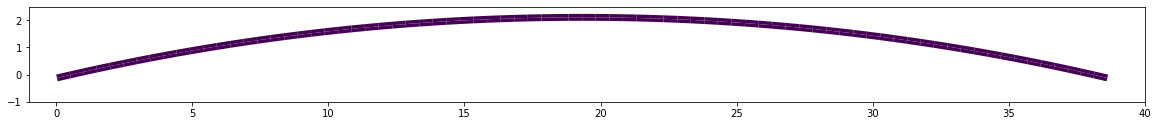

In [92]:
# plot mesh to check
## Plot the mesh 
fig, ax = plt.subplots(figsize=(20,40))
ax.set_xlim([-1, 40])
ax.set_ylim([-1, 2.5])
ax.set_aspect('equal')
patches = []
#viridis = matplotlib.cm.get_cmap('viridis', 50)
colors = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], closed=True)
    patches.append(polygon)
    colors[i] = 100.
p = PatchCollection(patches)
p.set_array(colors)
ax.add_collection(p)

In [4]:
# Shape functions and derivatives 

def Nvec(xi,eta):
    return 0.25*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])

def dNvecdxi(xi,eta):
    return 0.25*np.array([[(-1)*(1-eta),(+1)*(1-eta),(+1)*(1+eta),(-1)*(1+eta)],\
                          [(1-xi)*(-1),(1+xi)*(-1),(1+xi)*(+1),(1-xi)*(+1)]])

## Functions to compute the element residual and mass matrix


In [83]:
# compute mass matrix 
def assembleMM():
    MM = np.zeros((n_node*2,n_node*2))
    # loop over elements
    for ei in range(n_elem): 
        # initialize the mass matrix for this element
        Me = np.zeros((8,8))
        # nodes that make up this element 
        node_ei = elements[ei]
        # reference coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_X_ei = np.zeros((4,2))
        # deformed coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_x_ei = np.zeros((4,2))
        for ni in range(4):
            node_X_ei[ni] = node_X[node_ei[ni]]
            node_x_ei[ni] = node_x[node_ei[ni]]

        # also, do a proper integration with four integration points 
        # Loop over integration points
        # location and weight of integration points 
        IP_xi = np.array([[-1./np.sqrt(3),-1./np.sqrt(3)],[+1./np.sqrt(3),-1./np.sqrt(3)],\
                          [+1./np.sqrt(3),+1./np.sqrt(3)],[-1./np.sqrt(3),+1./np.sqrt(3)]])
        IP_wi = np.array([1.,1.,1.,1.])
        for ip in range(4):
            xi  = IP_xi[ip,0]
            eta = IP_xi[ip,1]
            wi = IP_wi[ip]
            # eval shape functions 
            Ns = Nvec(xi,eta)
            # eval the isoparametric map for the reference and deformed points corresponding to xi,eta = 0
            X = np.zeros((2))
            x = np.zeros((2))
            for ni in range(4):
                X += Ns[ni]*node_X_ei[ni]
                x += Ns[ni]*node_x_ei[ni]

            # evaluate the Jacobians, first derivative of shape functions with respect to xi space then Jacobians 
            dNsdxi = dNvecdxi(xi,eta)
            dXdxi = np.zeros((2,2))
            dxdxi = np.zeros((2,2))
            for ni in range(4):
                dXdxi += np.outer(node_X_ei[ni],dNsdxi[:,ni])
                dxdxi += np.outer(node_x_ei[ni],dNsdxi[:,ni])
                
            # get gradient of basis function with respect to X using inverse jacobian 
            JinvT = np.linalg.inv(dXdxi).transpose()
            dNsdX = np.dot(JinvT,dNsdxi)

            # get gradient of basis function with respect to x using inverse jacobian, the other one 
            jinvT = np.linalg.inv(dxdxi).transpose()
            dNsdx = np.dot(jinvT,dNsdxi)

            # get the deformation gradient 
            F = np.zeros((2,2))
            for ni in range(4):
                F += np.outer(node_x_ei[ni],dNsdX[:,ni])
            detF = np.linalg.det(F)
            # deformed thickness
            h0 = 1.0 #mm
            h = (1./detF)*h0
            rho = 1e-3 # tonne/mm^3 
            for ni in range(4):
                for ci in range(2):
                    for nj in range(4):
                        for cj in range(2):
                            Me[ni*2+ci,nj*2+cj] += wi*np.linalg.det(dxdxi)*rho*Ns[ni]*Ns[nj]*np.eye(2)[ci,cj]*h
                            # global one 
                            MM[node_ei[ni]*2+ci,node_ei[nj]*2+cj] += wi*np.linalg.det(dxdxi)*rho*Ns[ni]*Ns[nj]*np.eye(2)[ci,cj]*h

                        
    return MM

In [84]:
# putting it inside a function
def assembleRR():
    # assemble total residual 
    RR = np.zeros((2*n_node))
    # assemble the total tangent 
    KK = np.zeros((n_node*2,n_node*2))
    # loop over elements
    for ei in range(n_elem): 
        # initialize the residual for this element
        Re = np.zeros((8))
        # initialize the tangent for this element
        Ke = np.zeros((8,8))

        # nodes that make up this element 
        node_ei = elements[ei]
        # reference coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_X_ei = np.zeros((4,2))
        # change to displacement
        node_u_ei = np.zeros((4,2))
        for ni in range(4):
            node_X_ei[ni] = node_X[node_ei[ni]]
            node_u_ei[ni] = node_un[node_ei[ni]] # note, using un 

        # also, do a proper integration with four integration points 
        # Loop over integration points
        # location and weight of integration points 
        IP_xi = np.array([[-1./np.sqrt(3),-1./np.sqrt(3)],[+1./np.sqrt(3),-1./np.sqrt(3)],\
                          [+1./np.sqrt(3),+1./np.sqrt(3)],[-1./np.sqrt(3),+1./np.sqrt(3)]])
        IP_wi = np.array([1.,1.,1.,1.])
        for ip in range(4):
            xi  = IP_xi[ip,0]
            eta = IP_xi[ip,1]
            wi = IP_wi[ip]
            # eval shape functions 
            Ns = Nvec(xi,eta)
            # eval the isoparametric map for the reference and deformed points corresponding to xi,eta = 0
            X = np.zeros((2))
            x = np.zeros((2))
            for ni in range(4):
                X += Ns[ni]*node_X_ei[ni]
                # note, changed to displacements 
                x += Ns[ni]*(node_X_ei[ni]+node_u_ei[ni]) 

            # evaluate the Jacobians, first derivative of shape functions with respect to xi space then Jacobians 
            dNsdxi = dNvecdxi(xi,eta)
            dXdxi = np.zeros((2,2))
            dxdxi = np.zeros((2,2))
            for ni in range(4):
                dXdxi += np.outer(node_X_ei[ni],dNsdxi[:,ni])
                dxdxi += np.outer(node_X_ei[ni]+node_u_ei[ni],dNsdxi[:,ni])

            # get gradient of basis function with respect to X using inverse jacobian 
            JinvT = np.linalg.inv(dXdxi).transpose()
            dNsdX = np.dot(JinvT,dNsdxi)

            # get gradient of basis function with respect to x using inverse jacobian, the other one 
            jinvT = np.linalg.inv(dxdxi).transpose()
            dNsdx = np.dot(jinvT,dNsdxi)

            # get the deformation gradient 
            F = np.zeros((2,2))
            for ni in range(4):
                F += np.outer(node_X_ei[ni]+node_u_ei[ni],dNsdX[:,ni])
            # compute the stress
            detF = np.linalg.det(F)
            b = np.dot(F,F.transpose())
            c1 = 0.1 # MPa
            p = 2*c1/(detF*detF)
            sigma = -p*np.eye(2) + 2*c1*b
            # for plane stress the deformed thickness is 
            h0 = 1.0 # mm 
            h = h0*(1./detF) # with h0 the reference thickness 

            # compute the variation of the symmetric velocity gradient by moving one node and one component
            # of that node at a time, except if the node is on the boundary in which case no variation is allowed
            for ni in range(4):
                for ci in range(2):
                    deltav = np.zeros((2))
                    # note, no worries about the boundary because we will get rid of the corresponding rows
                    # of the residual because they wont be zero 
                    deltav[ci] = 1
                    gradx_v = np.outer(deltav,dNsdx[:,ni])
                    deltad = 0.5*(gradx_v + gradx_v.transpose())
                    # integrate over the solid, for this case plane stress so going to change to scale 
                    # by the compression in the off plane direction 
                    Re[ni*2+ci] += wi*np.linalg.det(dxdxi)*np.tensordot(sigma,deltad)*h

                    # ASSEMBLE INTO GLOBAL RESIDUAL 
                    RR[node_ei[ni]*2+ci] += wi*np.linalg.det(dxdxi)*np.tensordot(sigma,deltad)*h
                    
                        
    return RR
                            
        

## Initialize, identify essential boundary conditions

In [157]:
# Initial conditions 
node_x = np.zeros(node_X.shape)
node_un_m1 = np.zeros((2*n_node))
node_un_p1 = np.zeros((2*n_node))
node_un = np.zeros((2*n_node))
node_vn = np.zeros((2*n_node))
node_an = np.zeros((2*n_node))
# initialize empty arrays for the essential and natural BC 
EBC_n = []
NBC_n = []
for i in range(n_node):
    X = node_X[i]
    # first initialize with the same as original
    node_x[i] = X
    # check which nodes are in either end of the beam 
    if X[0]<0.1 :
        EBC_n.append(i)
    elif X[0]>38.5:
        EBC_n.append(i)
    elif X[1]>2.2 and X[0]>19.2 and X[0]<20:
        NBC_n.append(i)
print('EBC nodes')
print(EBC_n)
print('NBC nodes')
print(NBC_n)
# start everything with 0, no need to solve anything for this time step 


EBC nodes
[0, 78, 79, 157, 158, 236]
NBC nodes
[38, 39]


In [161]:
## Loop over time! 
time = 0 # already solved for because that's just initial conditions 
dt = 1e-6 # [s] 
nsteps = 1000
# calculate the mass matrix only initially 
M = assembleMM()
Minv = np.linalg.inv(M)
# Row sum 
Mvec = np.zeros((2*n_node))
for i in range(2*n_node):
    Mvec[i] = np.sum(M[i,:])
# viscosity proportional to mass 
C = 0.05*M
Cvec = 0.05*Mvec
A = M+dt/2.*C 
Ainv = np.linalg.inv(A)
Avec = Mvec+dt/2.*Cvec
# Loop 
node_x_hist = []
for i in range(nsteps): 
    time += dt
    # force vector, just applying a force at two nodes, gradually increasing the force, then keep force constant 
    P = np.zeros((n_node*2))
    if time<1e-3:
        P[NBC_n[0]*2+1] = -time # N
        P[NBC_n[1]*2+1] = -time # N
    if time>=1e-3:
        P[NBC_n[0]*2+1] = -1e-3 # N
        P[NBC_n[1]*2+1] = -1e-3 # N
    # Compute the internal force vector
    R = assembleRR()
    # solve for the new displacements 
    #RHS = dt**2*(P-R) + dt/2.*np.dot(C,node_un_m1)+np.dot(M,2*node_un-node_un_m1)
    #node_un_p1 = np.dot(Ainv, RHS)
    RHS = dt**2*(P-R) + dt/2.*Cvec*node_un_m1+Mvec*(2*node_un-node_un_m1)
    node_un_p1 = (1./Avec)*RHS
    # make sure to satisfy EBC 
    for e in range(len(EBC_n)):
        node_un_p1[EBC_n[e]*2+0] = 0.0
        node_un_p1[EBC_n[e]*2+1] = 0.0
    # recomopute velocities and accelerations, although they are never used 
    node_vn = (node_un_p1 - node_un_m1)/(2*dt)
    node_an = (node_un_p1-2*node_un + node_un_m1)/dt**2 
    # get updated deformed configuration 
    node_x = node_X + node_un_p1.reshape(n_node,2)
    # save into a file at given time steps 
    if i%100==0:
        print('step %i'%i)
        node_x_hist.append(node_x)
    # reset for the next time step 
    node_un_m1 = node_un
    node_un = node_un_p1

step 0
step 100
step 200
step 300
step 400
step 500
step 600
step 700
step 800
step 900


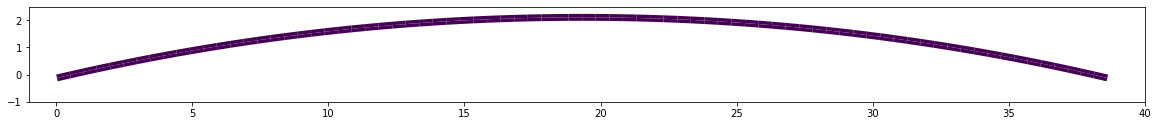

In [162]:
# plot mesh to check
## Plot the mesh 
fig, ax = plt.subplots(figsize=(20,40))
ax.set_xlim([-1, 40])
ax.set_ylim([-1, 2.5])
ax.set_aspect('equal')
patches = []
#viridis = matplotlib.cm.get_cmap('viridis', 50)
colors = np.zeros((n_elem))
ti=9
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x_hist[ti][n1],node_x_hist[ti][n2],node_x_hist[ti][n3],node_x_hist[ti][n4]], closed=True)
    patches.append(polygon)
    colors[i] = 100.
p = PatchCollection(patches)
p.set_array(colors)
ax.add_collection(p)